In [25]:
source("/home/user/data2/lit/bin/lit_utils.R")
source("/home/user/data3/lit/project/sORFs/sORFs.utils.R")
lib_text()
lib_plot()
library(ComplexHeatmap)
library(circlize)

In [26]:
orfs_path <- "../../results/1/all_samples.ibaq_b_with_total.tsv"
sample_metadata_path="../../MS_res_from_Galaxy/sample_metadata_ordered.txt"

fread_c(orfs_path) -> orfs
colnames(orfs)
head(orfs,1)
fread_c(sample_metadata_path) -> sample_metadata
head(sample_metadata,1)

[1] "ORF_id"                      "iBAQ_B"                     
 [3] "iBAQ_A"                      "Available"                  
 [5] "TotalIntensity"              "ORF_type"                   
 [7] "Start_codon"                 "Isoform_id"                 
 [9] "Chr"                         "Strand"                     
[11] "ORF_seq"                     "ORF_length"                 
[13] "Geneid"                      "Isoform_structural_category"
[15] "Isoform_subcategory"         "is_uniprot"                 
[17] "is_canonical"                "All_peptide_n"              
[19] "Unique_peptide_n"            "Theo_peptide_n"             
[21] "Sample"

,ORF_id,iBAQ_B,iBAQ_A,Available,TotalIntensity,ORF_type,Start_codon,Isoform_id,Chr,Strand,⋯,ORF_length,Geneid,Isoform_structural_category,Isoform_subcategory,is_uniprot,is_canonical,All_peptide_n,Unique_peptide_n,Theo_peptide_n,Sample
,<chr>,<dbl>,<dbl>,<lgl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<int>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<int>,<int>,<int>,<chr>
1,PB.10027.4:chr12:-|10|1315:112:1117|canonical|ATG,9794.914,40388.91,TRUE,3271501,canonical,ATG,PB.10027.4,chr12,-,⋯,334,LDHB,full-splice_match,reference_match,FALSE,TRUE,20,7,81,21pcw_1_3_30K_LC_T


,Sample,Eyzyme,Period,Enrichment,Replicate,ms2_count
,<chr>,<chr>,<chr>,<chr>,<int>,<int>
1,21pcw_1_C8_LC_T,Trypsin_LysC,21pcw,C8,1,120313


In [27]:
# 函数
merge_replicate <- function(df){
    # 合并重复
    df$Sample_merge_replicate <- gsub("21pcw(_1|_2|_3)", "21pcw", df$Sample)
    df %>% mutate(Sample=NULL) %>% rename(Sample=Sample_merge_replicate) -> df_1
    return(df_1)
}

In [28]:
# 过滤掉污染
orfs %>% filter(!grepl("Cont",ORF_id)) -> orfs
orfs %>% rename(Protein=ORF_id) -> orfs
# 对ORFs进行过滤，只保留小于等于150aa
# orfs %>% filter(ORF_length<=150) -> orfs
# 对样本进行过滤
sample_metadata %>% filter(Replicate!=4)  %>% filter(Eyzyme!='Null') -> sample_metadata

In [29]:
n_distinct(orfs$Protein)

[1] 41948

In [30]:
orfs %>% distinct(Protein,Sample) -> all_sample_sep
nrow(all_sample_sep)
n_distinct(all_sample_sep$Protein)
all_sample_sep %>% merge(sample_metadata,by = "Sample") -> all_sample_sep_m_meta
all_sample_sep_m_meta %>% arrange(Enrichment,Eyzyme,Replicate) -> all_sample_sep_m_meta
head(all_sample_sep_m_meta,1)
create_path( "../../results/1/S4/")
fwrite(all_sample_sep_m_meta,file = "../../results/1/S4/all_sample_sep_m_meta.txt",sep='\t')

[1] 169906

[1] 41948

,Sample,Protein,Eyzyme,Period,Enrichment,Replicate,ms2_count
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>
1,21pcw_1_C8_T_T,PB.10027.4:chr12:-|10|1315:112:1117|canonical|ATG,Trypsin,21pcw,C8,1,117437


In [11]:
merge_replicate(orfs) -> df
head(df,1)

,Protein,iBAQ_B,iBAQ_A,Available,TotalIntensity,ORF_type,Start_codon,Isoform_id,Chr,Strand,⋯,ORF_length,Geneid,Isoform_structural_category,Isoform_subcategory,is_uniprot,is_canonical,All_peptide_n,Unique_peptide_n,Theo_peptide_n,Sample
,<chr>,<dbl>,<dbl>,<lgl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<int>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<int>,<int>,<int>,<chr>
1,PB.10027.4:chr12:-|10|1315:112:1117|canonical|ATG,9794.914,40388.91,TRUE,3271501,canonical,ATG,PB.10027.4,chr12,-,⋯,334,LDHB,full-splice_match,reference_match,FALSE,TRUE,20,7,81,21pcw_3_30K_LC_T


# 饱和曲线图

In [18]:
output_path <- "../../figures/1"
##### Saturation Plot #####
set.seed(1234)
# sample_order <- sample(sample_metadata$Sample)
# sample_order <- sample_metadata %>% arrange(Enrichment,Eyzyme,Replicate) %>% .$Sample
sample_order <- merge_replicate(all_sample_sep_m_meta) %>% .$Sample %>% unique() %>% sample()
# 1. 蛋白累积分析（带柱状图）
res_protein <- cumu_combo_plot(
  df = df,
  sample_order = sample_order,
  target_col = "Protein",
  show_bar = TRUE
)
ggsave(res_protein$version_sampleNum,filename=o("cumu_pro_sample_n.pdf"),height = 5,width = 18)
ggsave(res_protein$version_sampleName,filename=o("cumu_pro_sample_name.pdf"),height = 5,width = 18)

# 被不同技术重复支持的次数

In [19]:
cus_plot <- function(df){
    # 查看蛋白在一种富集方法一种酶切方法中重复被检测到的次数
    count(df,Protein,Eyzyme,Enrichment) %>% 
    group_by(Eyzyme,Enrichment) %>% 
    count(n) -> df_1
    library(ggplot2)
    ggplot(df_1, aes(x=factor(n), y=nn, fill=Eyzyme)) +
    geom_bar(stat='identity', position='dodge') +
      scale_fill_brewer(palette = "Set3") +
    facet_wrap(~Enrichment) +
    labs(x='Number of technical replicates (same enrichment & digestion condition)\nsupporting protein existence', y='Frequency')+
    theme_3() -> p
    return(p)
}
all_sample_sep_m_meta %>% filter(grepl("^sp",Protein) |grepl("canonical",Protein)) -> all_sample_sep_m_meta_cano
n_distinct(all_sample_sep_m_meta_cano$Protein)
all_sample_sep_m_meta %>% filter(grepl("^PB",Protein) & !grepl("canonical",Protein))  -> all_sample_sep_m_meta_uncano
n_distinct(all_sample_sep_m_meta_uncano$Protein)
cus_plot(all_sample_sep_m_meta_cano) -> p
ggsave(p,filename=o("enrichmen_enzyme_tech_replicate_n_cano_protein.pdf"),height = 5,width = 8)
cus_plot(all_sample_sep_m_meta_uncano) -> p
ggsave(p,filename=o("enrichmen_enzyme_tech_replicate_n_uncano_protein.pdf"),height = 5,width = 8)

[1] 7736

[1] 34212

Storing counts in `nn`, as `n` already present in input
ℹ Use `name = "new_name"` to pick a new name.
Storing counts in `nn`, as `n` already present in input
ℹ Use `name = "new_name"` to pick a new name.


# 热图

In [20]:
merge_replicate <- function(df){
    # 合并重复
    df$Sample_merge_replicate <- gsub("21pcw(_1|_2|_3)", "21pcw", df$Sample)
    distinct(df,Protein,Sample_merge_replicate,Eyzyme,Enrichment) -> df_1
    df_1 %>% rename(Sample=Sample_merge_replicate) -> df_2
    return(df_2)
}
define_type <- function(x){
    return(if_else(grepl("^sp",x) |grepl("canonical",x),"Cano","Uncano"))
}

df <- merge_replicate(all_sample_sep_m_meta)
protein_stats <- df %>%
  group_by(Protein) %>%
  summarise(
    Unique_Methods = n_distinct(Enrichment),  # 被多少种不同富集方法鉴定到
    Total_Observations = n(),                 # 被鉴定到的总次数
    Supported_Enrichments = paste(sort(unique(Enrichment)), collapse = ", ")  # 支持的富集方法（去重后逗号分隔）
  )
protein_stats$Unique_Methods <- as.character(protein_stats$Unique_Methods)
protein_stats$Unique_Methods <- factor(protein_stats$Unique_Methods,levels=c('4','3','2','1'))
protein_stats$Type <- factor(define_type(protein_stats$Protein),levels = c("Cano","Uncano"))
protein_stats %>% arrange(Type,Unique_Methods, Supported_Enrichments,desc(Total_Observations)) -> protein_stats

Loading required package: grid

ComplexHeatmap version 2.14.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))
! pheatmap() has been masked by ComplexHeatmap::pheatmap(). Most of the arguments
   in the original pheatmap() are identically supported in the new function. You 
   can still use the original function by explicitly calling pheatmap::pheatmap().



Attaching package: ‘Co

png 
  2

[1] "2x2列联表:"
                  
                    Cano Uncano
  Unique_Methods=1  3672  31879
  Unique_Methods>1  4064   2333
[1] "\n卡方检验结果:"

	Pearson's Chi-squared test with Yates' continuity correction

data:  contingency_table
X-squared = 10198, df = 1, p-value < 2.2e-16

[1] "\n期望频数:"
                  
                       Cano    Uncano
  Unique_Methods=1 6556.273 28994.727
  Unique_Methods>1 1179.727  5217.273


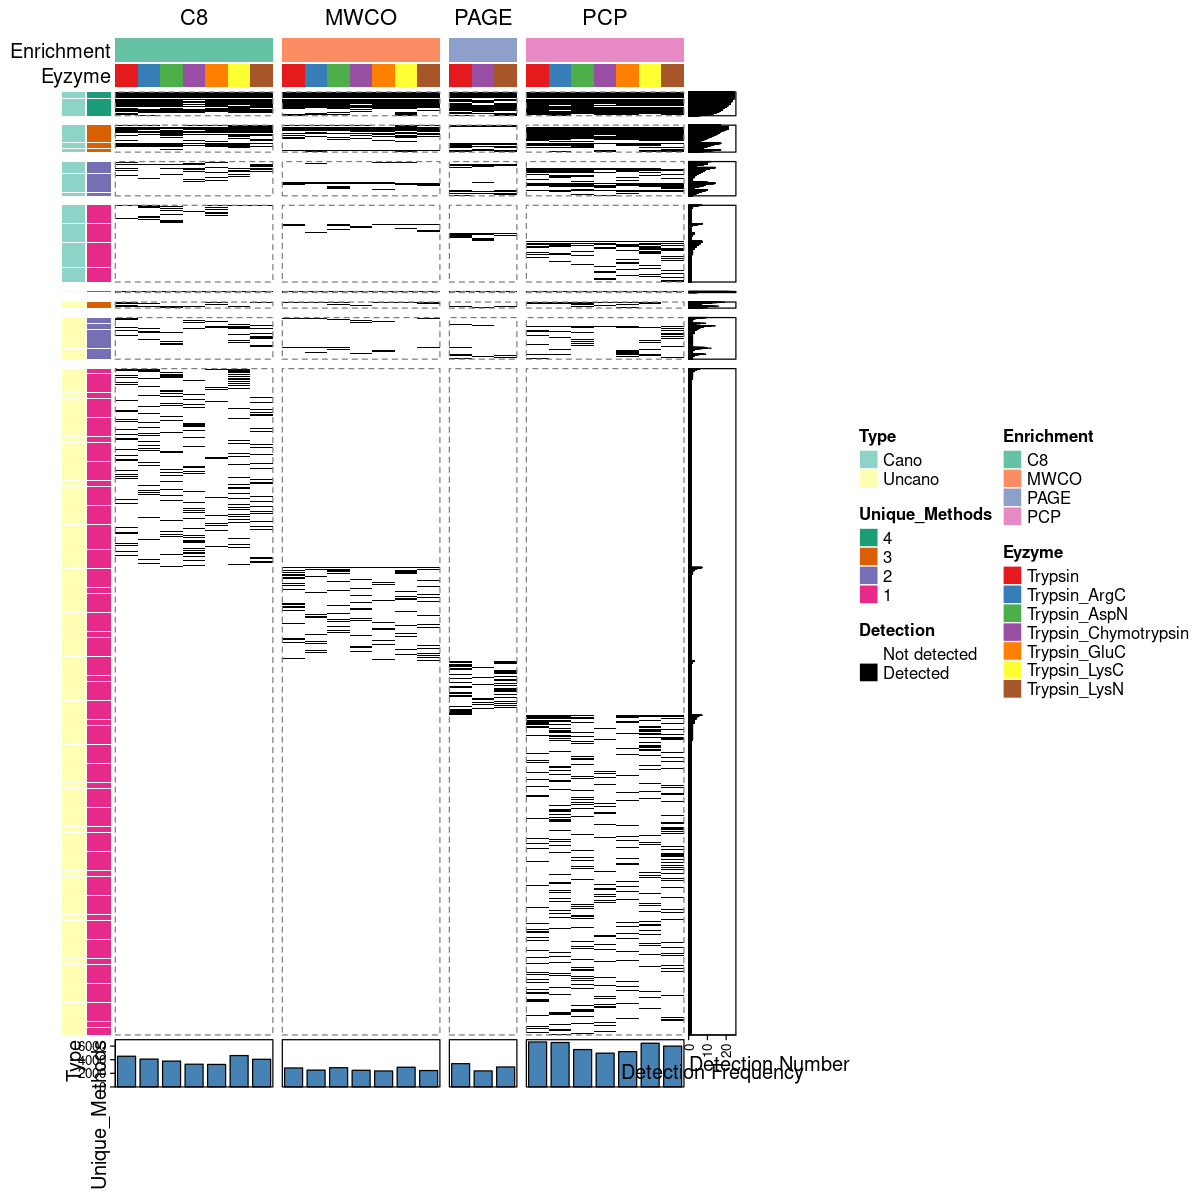

In [21]:
library(ComplexHeatmap)
library(circlize)
# Create a binary detection matrix
binary_matrix_tmp <- df %>%
  mutate(present = 1) %>%
  select(Sample, Protein, present) %>%
  pivot_wider(names_from = Sample, values_from = present, values_fill = 0) %>%
  column_to_rownames("Protein") %>%
  as.matrix()
# 按照特定顺序排序
binary_matrix_tmp[protein_stats$Protein,] -> binary_matrix
# Calculate detection frequency for each protein
detection_freq <- rowSums(binary_matrix)
detection_number <- colSums(binary_matrix)

# Get unique sample annotations
sample_annot <- df %>%
  select(Sample,Enrichment,Eyzyme) %>%
  distinct() %>%
  column_to_rownames("Sample")

# Define colors for annotations
enzyme_colors <- setNames(brewer.pal(length(unique(sample_annot$Eyzyme)), "Set1"), 
                          unique(sample_annot$Eyzyme))
enrichment_colors <- setNames(brewer.pal(length(unique(sample_annot$Enrichment)), "Set2"), 
                              unique(sample_annot$Enrichment))
# Create column annotations
col_ha <- HeatmapAnnotation(
  df = sample_annot,
  col = list(
    Eyzyme = enzyme_colors,
    Enrichment = enrichment_colors
  ),
  annotation_name_side = "left"
)

# Create row annotation for detection frequency
row_ha <- rowAnnotation(
  "Detection Frequency" = anno_barplot(detection_freq, 
                                       bar_width = 0.8,
                                       gp = gpar(fill = "steelblue",col=NULL))
)
col_ha_1 <- columnAnnotation(
  "Detection Number" = anno_barplot(detection_number, 
                                       bar_width = 0.8,
                                       gp = gpar(fill = "steelblue",col=NULL))
)

# Define colors for annotations
type_colors <- setNames(brewer.pal(length(unique(protein_stats$Type)), "Set3"), 
                          unique(protein_stats$Type))
method_colors <- setNames(brewer.pal(length(unique(protein_stats$Unique_Methods)), "Dark2"), 
                              unique(protein_stats$Unique_Methods))
protein_stats[,c("Type","Unique_Methods")]  %>% as.data.frame() -> row_anno
rownames(row_anno) <- protein_stats$Protein
# Create column annotations
row_ha_1 <- rowAnnotation(
  df = row_anno,
  col = list(
    Type = type_colors[1:2],
    Unique_Methods = method_colors
  ),
  annotation_name_side = "bottom"
)

column_split <- factor(
  sample_annot$Enrichment, 
  levels = unique(sample_annot$Enrichment) 
)
groups <- paste0(protein_stats$Type,"-",protein_stats$Unique_Methods)
row_split <- factor(
    groups, 
    levels = unique(groups)
)

options(repr.plot.width = 10, repr.plot.height = 10)
ht <- Heatmap(
    binary_matrix,
    name = "Detection",
    col = c("white", "black"),
    cluster_columns = FALSE,
    clustering_distance_columns="binary",
    cluster_rows = FALSE,
    row_title=NULL,
    show_row_names = FALSE,
    show_column_names = FALSE,
    top_annotation = col_ha,
    right_annotation = row_ha,
    left_annotation = row_ha_1,
    bottom_annotation = col_ha_1,
    column_split = column_split,
    row_split = row_split,
    heatmap_legend_param = list(
        at = c(0, 1),
        labels = c("Not detected", "Detected")
    ),
    use_raster = FALSE,
    # 添加虚线分隔
    row_gap = unit(2, "mm"),
    column_gap = unit(2, "mm"),
    border_gp = gpar(lty = "dashed", col = "grey50")  # 替代方法
)
ht

# Draw the heatmap
# 1. 打开 PDF 设备，设置文件名和尺寸（单位：英寸）
pdf(o("protein_detection_heatmap.pdf"), width = 12, height = 12)
# 2. 绘制热图（假设 `ht` 是你的 Heatmap 对象）
draw(ht)
# 3. 关闭设备，保存文件
dev.off()

# 自动生成2x2列联表
library(dplyr)

# 创建分组变量
protein_stats_grouped <- protein_stats %>%
  mutate(
    Group = case_when(
      Unique_Methods == "1" ~ "Unique_Methods=1",
      Unique_Methods %in% c("2", "3", "4") ~ "Unique_Methods>1"
    )
  )

# 生成列联表
contingency_table <- table(protein_stats_grouped$Group, protein_stats_grouped$Type)
print("2x2列联表:")
print(contingency_table)

# 进行卡方检验
chi_test <- chisq.test(contingency_table)
print("\n卡方检验结果:")
print(chi_test)

# 检查期望频数
print("\n期望频数:")
print(chi_test$expected)

# 如果期望频数<5，使用Fisher精确检验
if(any(chi_test$expected < 5)) {
  print("\n期望频数<5，使用Fisher精确检验:")
  fisher_test <- fisher.test(contingency_table)
  print(fisher_test)
}

In [22]:
colnames(protein_stats_grouped)
protein_stats_grouped %>% group_by(Type,Unique_Methods) %>% summarise(n=n())

[1] "Protein"               "Unique_Methods"        "Total_Observations"   
[4] "Supported_Enrichments" "Type"                  "Group"

`summarise()` has grouped output by 'Type'. You can override using the
`.groups` argument.


Type,Unique_Methods,n
<fct>,<fct>,<int>
Cano,4,1135
Cano,3,1290
Cano,2,1639
Cano,1,3672
Uncano,4,51
Uncano,3,291
Uncano,2,1991
Uncano,1,31879
